In [4]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session9'
sys.path.append(workingdir)

In [0]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import gradcam 
from utils import gradvisualize 

In [7]:
classes, trainloader, testloader = datapreparation.load(albumentations=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


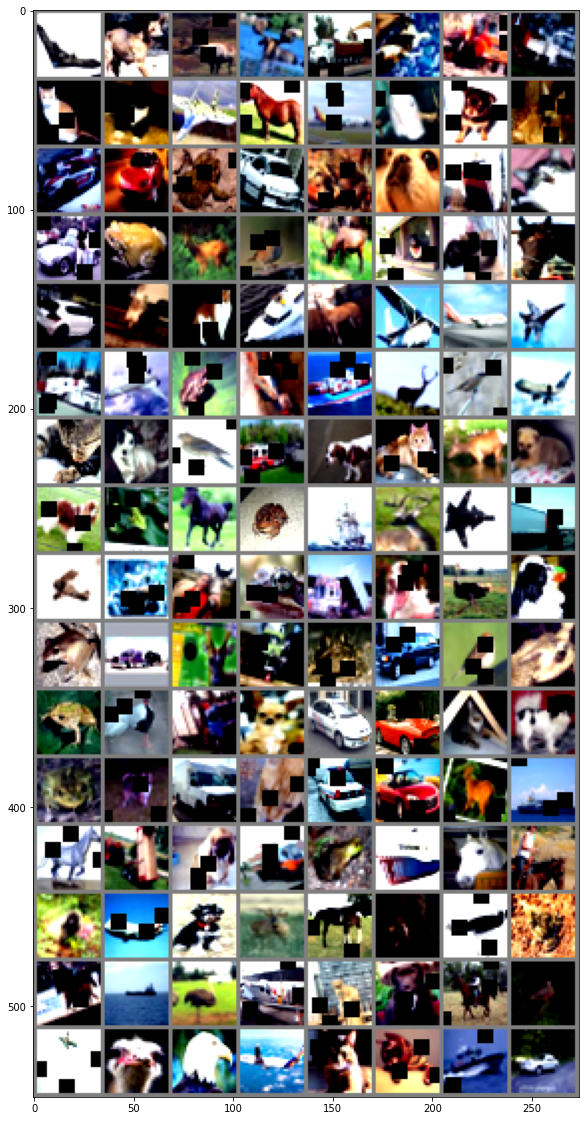

In [8]:
display.show_images(trainloader, classes, 20)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18()
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder = lrfinder.LRFinder(model,optimizer,criterion,device=device)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


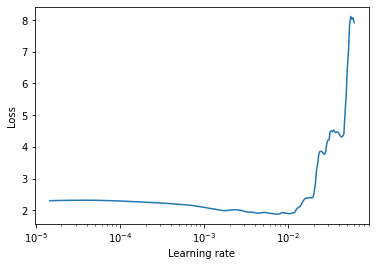

In [7]:
lr_finder.range_test(trainloader, testloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [8]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss,best_lr))

Best Loss: 1.880715959615899
Best Learning Rate: 0.007722774850140124


In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(model.parameters(), lr=0.best_lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)

In [16]:
EPOCHS = 20
misclassified_imgs = []
correct_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    trainacc,trainlosses = training.train_model(model, device, trainloader, optimizer, criterion, epoch)
    testacc, testlosses, misclassified_imgs, correct_imgs = training.test_model(model, device, criterion, testloader, epoch==EPOCHS-1)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.0444056987762451 Batch_id=390 Accuracy=47.78: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6040/10000 (60.40%)

EPOCH: 2


Loss=0.9992778897285461 Batch_id=390 Accuracy=65.29: 100%|██████████| 391/391 [00:32<00:00, 12.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 6562/10000 (65.62%)

EPOCH: 3


Loss=0.527289867401123 Batch_id=390 Accuracy=72.71: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7761/10000 (77.61%)

EPOCH: 4


Loss=0.6854153275489807 Batch_id=390 Accuracy=77.04: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7926/10000 (79.26%)

EPOCH: 5


Loss=0.4758724570274353 Batch_id=390 Accuracy=79.53: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8157/10000 (81.57%)

EPOCH: 6


Loss=0.6895855665206909 Batch_id=390 Accuracy=81.76: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8162/10000 (81.62%)

EPOCH: 7


Loss=0.5200798511505127 Batch_id=390 Accuracy=83.40: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8013/10000 (80.13%)

EPOCH: 8


Loss=0.45541149377822876 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8341/10000 (83.41%)

EPOCH: 9


Loss=0.4031049609184265 Batch_id=390 Accuracy=85.74: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8398/10000 (83.98%)

EPOCH: 10


Loss=0.46109190583229065 Batch_id=390 Accuracy=87.02: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8406/10000 (84.06%)

EPOCH: 11


Loss=0.4288802146911621 Batch_id=390 Accuracy=87.90: 100%|██████████| 391/391 [00:32<00:00, 12.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8614/10000 (86.14%)

EPOCH: 12


Loss=0.3247317373752594 Batch_id=390 Accuracy=88.68: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8581/10000 (85.81%)

EPOCH: 13


Loss=0.3472965657711029 Batch_id=390 Accuracy=89.59: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8563/10000 (85.63%)

EPOCH: 14


Loss=0.4080798029899597 Batch_id=390 Accuracy=90.18: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8528/10000 (85.28%)

EPOCH: 15


Loss=0.2856042683124542 Batch_id=390 Accuracy=90.62: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8381/10000 (83.81%)

EPOCH: 16


Loss=0.2195562869310379 Batch_id=390 Accuracy=91.36: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8714/10000 (87.14%)

EPOCH: 17


Loss=0.1674846112728119 Batch_id=390 Accuracy=91.66: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8740/10000 (87.40%)

EPOCH: 18


Loss=0.32987552881240845 Batch_id=390 Accuracy=92.23: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8608/10000 (86.08%)

EPOCH: 19


Loss=0.2303413450717926 Batch_id=390 Accuracy=92.82: 100%|██████████| 391/391 [00:32<00:00, 12.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8814/10000 (88.14%)

EPOCH: 20


Loss=0.27770280838012695 Batch_id=390 Accuracy=93.10: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]



Test set: Average loss: 0.0030, Accuracy: 8828/10000 (88.28%)



GroundTruth:    dog  frog   cat plane  deer
Predicted:    dog  frog   cat plane  bird


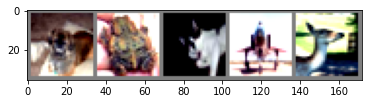

In [17]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [18]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 88 %


In [19]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 86 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 64 %
Accuracy of  deer : 85 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 86 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %


Visualize GradCam

In [20]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradvisualize.VisualizeCam(model, classes, target_layers)
print (viz_cam)

In [21]:
#len(testloader.dataset)
print(misclassified_imgs[0]["img"])

tensor([[[-1.4812, -1.4812, -1.2431,  ..., -1.7670, -1.7193, -1.7035],
         [-1.5606, -1.4653, -0.5605,  ..., -1.7193, -1.7193, -1.7352],
         [-1.6082, -0.9574,  0.4396,  ..., -1.5130, -1.6241, -1.7352],
         ...,
         [-1.3383, -1.3701, -1.3860,  ...,  1.8842,  1.8683,  1.9160],
         [-1.3542, -1.3383, -1.3542,  ...,  1.9795,  1.8683,  1.9318],
         [-1.4018, -1.3860, -1.3225,  ...,  1.9160,  1.8525,  1.8683]],

        [[-1.4971, -1.5776, -1.4165,  ..., -1.8031, -1.7548, -1.7386],
         [-1.5615, -1.5776, -0.8850,  ..., -1.7548, -1.7548, -1.7709],
         [-1.6420, -1.1588, -0.0636,  ..., -1.5293, -1.6581, -1.7709],
         ...,
         [-0.9495, -0.9978, -1.0622,  ...,  1.6114,  1.5953,  1.6114],
         [-0.9656, -0.9656, -1.0139,  ...,  1.6597,  1.5631,  1.6114],
         [-1.0461, -0.9978, -0.9656,  ...,  1.5631,  1.5309,  1.5470]],

        [[-1.3622, -1.4072, -1.2872,  ..., -1.6171, -1.5721, -1.5571],
         [-1.4222, -1.4521, -0.9274,  ..., -1

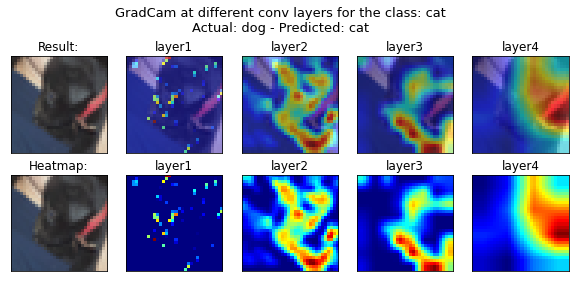

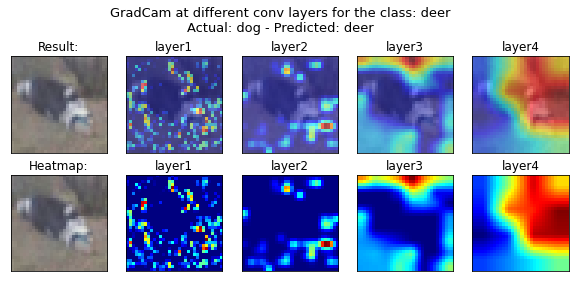

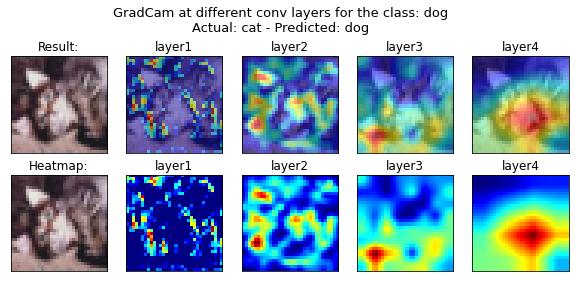

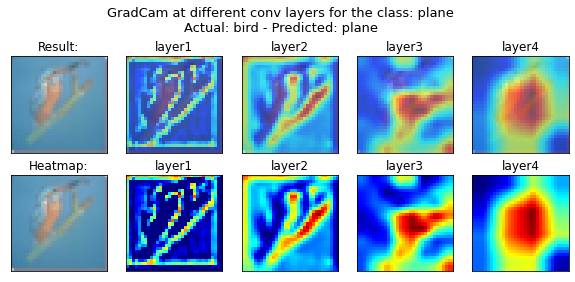

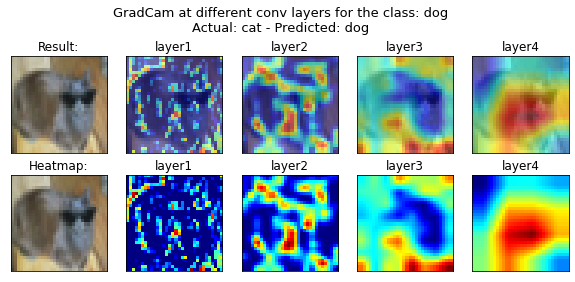

In [22]:
#GradCam for incorrectly classified images

num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

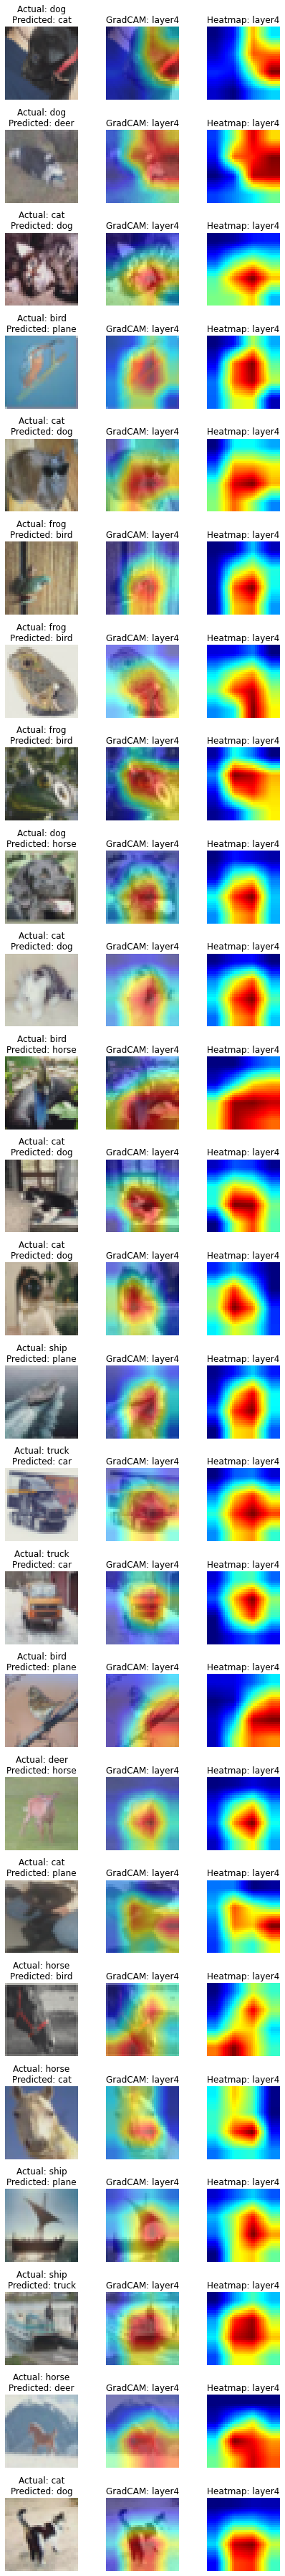

In [23]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)

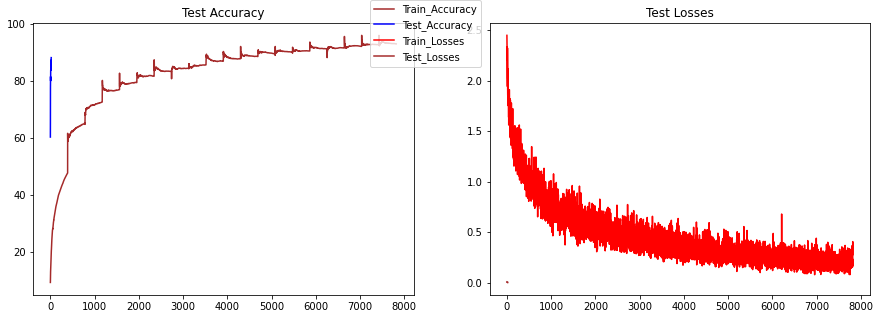

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(trainacc, color='brown',label='Train_Accuracy')
axs[0].set_title("Train Accuracy")
axs[0].plot(testacc, color='blue',label='Test_Accuracy')
axs[0].set_title("Test Accuracy")
axs[1].plot(trainlosses, color='red',label='Train_Losses')
axs[1].set_title("Train Losses")
axs[1].plot(testlosses, color='brown',label='Test_Losses')
axs[1].set_title("Test Losses")
fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))